 # Assignment 3
 Imports and setting seeds

In [1]:
import pandas as pd
import sklearn
import numpy
import surprise
import matplotlib
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import Dataset
from surprise import SVD
from surprise import accuracy
numpy.random.seed(0)
RELEVANCE_THRESHOLD = 3.5

## Data processing and some statistics

All genres:  {'Adventure', 'Film-Noir', 'War', 'IMAX', 'Crime', 'Documentary', 'Western', 'Action', 'Children', 'Animation', 'Drama', '(no genres listed)', 'Romance', 'Horror', 'Musical', 'Mystery', 'Sci-Fi', 'Fantasy', 'Thriller', 'Comedy'}
Amount of ratings:  97801
Amount of users:  600
Amount of movies:  9680
Amount of movies that are rated before release:  3
Interval of dataset:  1996-03-29 18:36:55 - 2018-09-24 14:27:30
Rating counts:  rating
0.5     1329
1.0     2735
1.5     1714
2.0     7366
2.5     5261
3.0    19560
3.5    12586
4.0    26074
4.5     8232
5.0    12944
Name: count, dtype: int64
Date counts:  release_year
1902       5
1903       2
1908       1
1915       1
1916       5
        ... 
2014    1313
2015    1088
2016     787
2017     460
2018     104
Name: count, Length: 106, dtype: int64
Ratings per user counts:  19       1
20      16
21      12
22      14
23      12
        ..
1346     1
1863     1
2108     1
2477     1
2698     1
Name: count, Length: 258, dtype: int

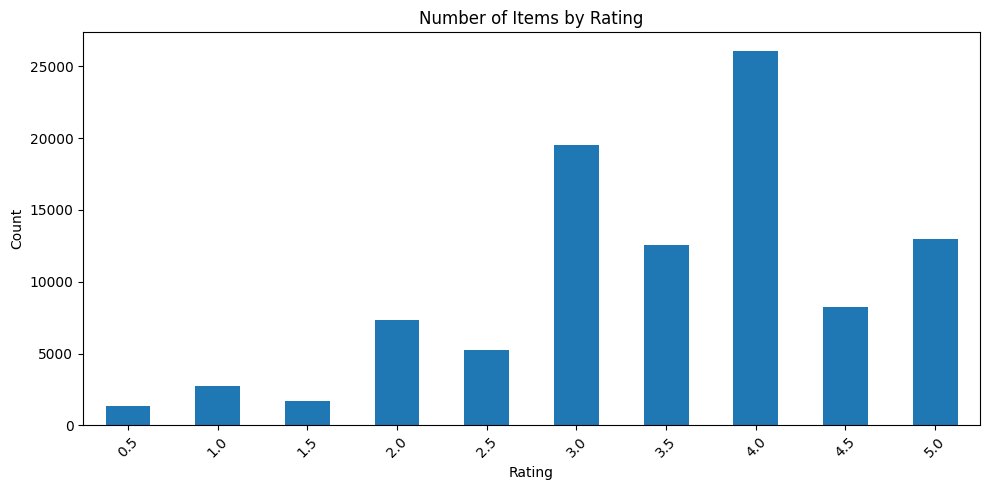

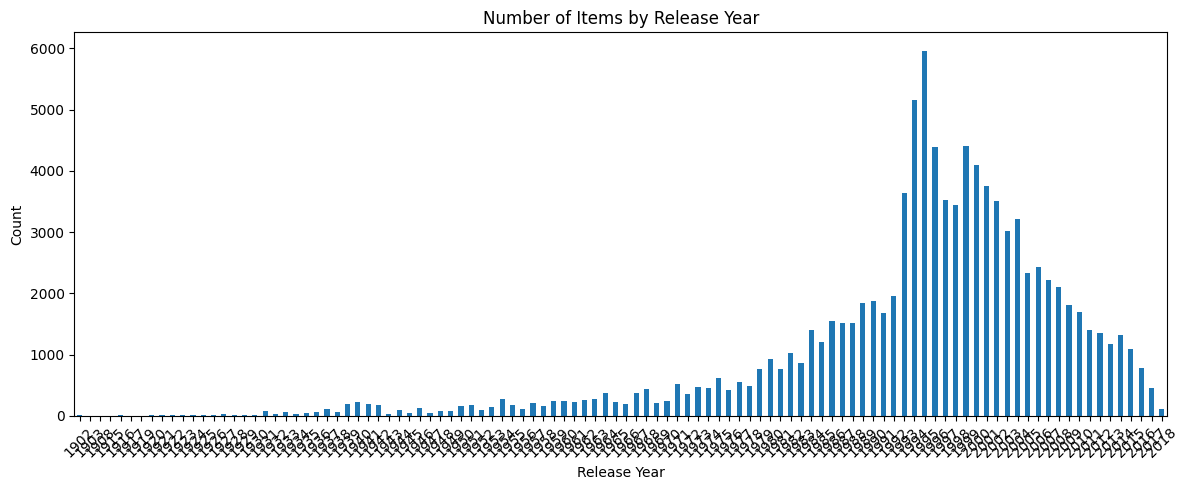

,userId,movieId,rating,timestamp,title,genres,Adventure,Film-Noir,War,IMAX,...,(no genres listed),Romance,Horror,Musical,Mystery,Sci-Fi,Fantasy,Thriller,Comedy,release_year
0,1,1,4.0,2000-07-30 18:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,0,0,0,...,0,0,0,0,0,0,1,0,1,1995
1,1,3,4.0,2000-07-30 18:20:47,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1995
2,1,6,4.0,2000-07-30 18:37:04,Heat (1995),Action|Crime|Thriller,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1995
3,1,47,5.0,2000-07-30 19:03:35,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1995
4,1,50,5.0,2000-07-30 18:48:51,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97796,610,166534,4.0,2017-05-03 21:53:22,Split (2017),Drama|Horror|Thriller,0,0,0,0,...,0,0,1,0,0,0,0,1,0,2017
97797,610,168248,5.0,2017-05-03 22:21:31,John Wick: Chapter Two (2017),Action|Crime|Thriller,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2017
97798,610,168250,5.0,2017-05-08 19:50:47,Get Out (2017),Horror,0,0,0,0,...,0,0,1,0,0,0,0,0,0,2017
97799,610,168252,5.0,2017-05-03 21:19:12,Logan (2017),Action|Sci-Fi,0,0,0,0,...,0,0,0,0,0,1,0,0,0,2017


In [2]:
from matplotlib import pyplot as plt

movies_df = pd.read_csv("movies.csv")


num_cols = movies_df.select_dtypes(include=["int64", "float64"]).columns
cat_cols = movies_df.select_dtypes(include=["object"]).columns

rating_df = pd.read_csv("ratings_train.csv")
rating_df['timestamp'] = pd.to_datetime(rating_df['timestamp'], unit='s')

movies_df = movies_df[~movies_df.eq("").any(axis=1)]
rating_df = rating_df[~rating_df.eq("").any(axis=1)]

combined_dataset = rating_df.join(movies_df.set_index('movieId'), on='movieId')

all_categories = set(genre for all_genres in combined_dataset['genres'] for genre in all_genres.split('|'))

for category in all_categories:
    combined_dataset[category] = combined_dataset['genres'].apply(lambda x: 1 if category in x else 0)

combined_dataset['release_year'] = combined_dataset['title'].str.extract(r'\((19[0-9]{2}|20[0-9]{2})\)').astype('Int64')

min_year_per_movie = combined_dataset['timestamp'].dt.year.groupby(combined_dataset['movieId']).transform('min').astype('Int64')

# Fill NaNs in release_year with the smallest year for that movie_id
combined_dataset['release_year'] = combined_dataset['release_year'].fillna(min_year_per_movie)

print("All genres: ", all_categories)
print("Amount of ratings: ", len(combined_dataset['movieId']))
print("Amount of users: ", len(combined_dataset['userId'].unique()))
print("Amount of movies: ", len(combined_dataset['movieId'].unique()))
print("Amount of movies that are rated before release: ", len(combined_dataset[combined_dataset['timestamp'].dt.year < combined_dataset['release_year']]))
print("Interval of dataset: ", combined_dataset["timestamp"].min(), "-", combined_dataset["timestamp"].max())

rating_counts = combined_dataset.groupby('rating')[['rating']].value_counts()
year_counts = combined_dataset.groupby('release_year')[['release_year']].value_counts()
ratings_per_user = combined_dataset.groupby('userId').size()

# Step 2: Count how many users have each rating count
user_rating_distribution = ratings_per_user.value_counts().sort_index()

print("Rating counts: ", rating_counts)
print("Date counts: ", year_counts)
print("Ratings per user counts: ", user_rating_distribution)

# Plot ratings
plt.figure(figsize=(10, 5))
rating_counts.plot(kind='bar')
plt.title('Number of Items by Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('rating_distribution.png')
plt.show()

# Plot release years
plt.figure(figsize=(12, 5))
year_counts.plot(kind='bar')
plt.title('Number of Items by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

combined_dataset

## Train - test split

In [3]:
ratings_test_df = pd.read_csv("ratings_test.csv")

print("Percentage of users in the to fill in dataset that is not present in training: ", len(set(ratings_test_df["userId"]) - set(combined_dataset["userId"]))/len(ratings_test_df["userId"]))

Percentage of users in the to fill in dataset that is not present in training:  0.1


In [4]:
def split_data_train_test(combined_dataset, size_testset = 100, per_cold_start_users = 0.1, per_test_movies = 0.1):
    # Shuffle dataset
    combined_dataset = combined_dataset.sample(frac=1, random_state=42).reset_index(drop=True)

    # Step 1: Select 100 unique users for the test set
    unique_users = combined_dataset['userId'].unique()
    test_user_count = size_testset
    assert test_user_count <= len(unique_users), "Not enough users in dataset to select 100 test users."

    test_users = np.random.choice(unique_users, size=test_user_count, replace=False)

    # Step 2: Select 10% of test users as cold-start (only in test)
    n_cold_users = int(per_cold_start_users * test_user_count)
    cold_users = np.random.choice(test_users, size=n_cold_users, replace=False)
    known_test_users = set(test_users) - set(cold_users)

    # Step 3: Split the data
    cold_user_data = combined_dataset[combined_dataset['userId'].isin(cold_users)]
    non_test_data = combined_dataset[~combined_dataset['userId'].isin(test_users)]
    known_user_data = combined_dataset[combined_dataset['userId'].isin(known_test_users)]

    # Step 4: For known test users, move per_test_movies of their ratings to test set, keep 1 - per_test_movies in training
    def split_user_ratings_time_based(df):
        df = df.sort_values('timestamp')  # Sort by time
        n_test = max(1, int(per_test_movies * len(df)))
        return df.iloc[:-n_test], df.iloc[-n_test:]

    train_parts = []
    test_parts = []

    for user_id, group in known_user_data.groupby('userId'):
        train_chunk, test_chunk = split_user_ratings_time_based(group)
        train_parts.append(train_chunk)
        test_parts.append(test_chunk)

    # Step 5: Combine everything
    df_train = pd.concat([non_test_data] + train_parts).reset_index(drop=True)
    df_test = pd.concat([cold_user_data] + test_parts).reset_index(drop=True)

    test_users_final = set(df_test['userId'])
    train_users_final = set(df_train['userId'])
    cold_user_pct = len(test_users_final - train_users_final) / len(test_users_final)

    print("Total users in test set:", len(test_users_final))
    print("Cold users (only in test):", len(test_users_final - train_users_final))
    print("Percentage of cold users in test set:", round(cold_user_pct * 100, 2), "%")
    return df_train, df_test


In [5]:
import numpy as np

sorted_on_timestamp = combined_dataset.sort_values('timestamp')

# 3. Split into 80% train and 20% test
split_index = int(0.8 * len(sorted_on_timestamp))
df_train = sorted_on_timestamp.iloc[:split_index]
df_test = sorted_on_timestamp.iloc[split_index:]

print("Percentage of users in test dataset that is not present in training when using (based on time): ", len(set(df_test["userId"]) - set(df_train["userId"]))/len(set(df_test["userId"])))

reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(combined_dataset[['userId', 'movieId', 'rating']], reader)
df_train, df_test = train_test_split(data, test_size=0.2)
train_users = set([df_train.to_raw_uid(u) for u in df_train.all_users()])
test_users = set([uid for (uid, _, _) in df_test])
print("Percentage of users in test dataset that is not present in training when using (20-80 split): ", len(test_users - train_users)/len(test_users))


sorted_on_userId = combined_dataset.sort_values('userId')
split_index = int(0.8 * len(sorted_on_userId))
df_train = sorted_on_userId.iloc[:split_index]
df_test = sorted_on_userId.iloc[split_index:]

Percentage of users in test dataset that is not present in training when using (based on time):  0.7543859649122807
Percentage of users in test dataset that is not present in training when using (20-80 split):  0.0


## Performance testing functions

## Building Recommender Models and Evaluation

### Get score

In [6]:
def test_model(algo, train_df, test_df):
    # Prepare training data
    reader = Reader(rating_scale=(0.5, 5.0))
    train_data = Dataset.load_from_df(train_df[["userId", "movieId", "rating"]], reader)
    trainset = train_data.build_full_trainset()
    test_data = Dataset.load_from_df(train_df[["userId", "movieId", "rating"]], reader)
    testset = trainset.build_testset()

    # Fit model
    algo.fit(trainset)

    # Predict
    predictions = algo.test(testset)
    rmse = accuracy.rmse(predictions, verbose=False)
    # Evaluate
    return rmse


### Recomendation code

In [7]:
from collections import defaultdict
import pandas as pd
from surprise import Dataset, Reader, KNNWithMeans

def get_top_watched_movies(df, k=10):
    # Group by movieId and calculate average rating and count
    df_grouped = df.groupby("movieId").agg(
        average_rating=("rating", "mean"),
        count=("rating", "count")
    )
    average_rating = df_grouped[df_grouped["average_rating"] > 3.5]
    # Get top k by count of ratings
    top_k = average_rating.sort_values(by="count", ascending=False).head(k)

    # Return list of (movieId, average_rating) tuples
    return list(zip(top_k.index, top_k["average_rating"]))

def precision_recall_at_k_from_output(rec_df, test_df, k=10, relevance_threshold=3.5):
    # Create mapping: user_id -> set of relevant items in test set
    relevant_items = (
        test_df[test_df["rating"] >= relevance_threshold]
        .groupby("userId")["movieId"]
        .apply(set)
        .to_dict()
    )

    precisions = []
    recalls = []

    for _, row in rec_df.iterrows():
        user_id = row["user_id"]
        recommended_items = set(row[[f"recommendation{i+1}" for i in range(k)]].values)
        relevant = relevant_items.get(user_id, set())

        if not relevant:
            continue

        true_positives = recommended_items & relevant
        precision = len(true_positives) / k
        recall = len(true_positives) / len(relevant)

        precisions.append(precision)
        recalls.append(recall)

    avg_precision = sum(precisions) / len(precisions) if precisions else 0.0
    avg_recall = sum(recalls) / len(recalls) if recalls else 0.0

    return avg_precision, avg_recall


def run_model(algo, trainig_df, test_df, full_df, amount_of_pred = 10, fit=True, keep_scores=False):
    reader = Reader(rating_scale=(0.5, 5.0))
    data = Dataset.load_from_df(trainig_df[["userId", "movieId", "rating"]], reader)
    trainset = data.build_full_trainset()

    if fit:
        algo.fit(trainset)

    all_movie_ids = set(full_df['movieId'].unique())
    user_rated = trainig_df.groupby('userId')['movieId'].apply(set).to_dict()

    top_n_recs = []
    for user_id in test_df['userId'].unique():
        rated = user_rated.get(user_id, set())
        unrated = all_movie_ids - rated
        assert len(unrated) != 0, "No unrated movies for user {}".format(user_id)
        user_pred = []
        for movie_id in unrated:
            pred = algo.predict(user_id, movie_id)
            if pred.details['was_impossible']:
                continue
            user_pred.append((pred.iid, pred.est))
            user_pred = sorted(user_pred, key=lambda x: x[1], reverse=True)[:amount_of_pred]
        if len(user_pred) < amount_of_pred:
            user_pred = list(set(user_pred + get_top_watched_movies(trainig_df, amount_of_pred)))[:amount_of_pred]
        if keep_scores:
            top_n_recs.append([user_id] + [item for item in user_pred])
        else:
            top_n_recs.append([user_id] + [item[0] for item in user_pred])

    rec_df = pd.DataFrame(top_n_recs, columns=["user_id"] + ["recommendation" + str(item + 1) for item in range(0,amount_of_pred)])

    print("Fast batch recommendations saved to 'user_recommendations.csv'")

    return rec_df

In [8]:
df_train, df_test = split_data_train_test(combined_dataset, 100, 0.1,0.2)

algo = KNNWithMeans(sim_options={'name': 'cosine', 'user_based': True})
rmse = test_model(algo, df_train, df_test)
print(rmse)

pred = algo.predict(df_test.iloc[0]["userId"], 4)
print(pred)


pred = algo.predict(df_test.iloc[-1]["userId"], 4)
print(pred)

test_model(algo, df_train, df_test)
rec_df = run_model(algo, df_train, df_test, combined_dataset, 10)

k = 10
precision, recall = precision_recall_at_k_from_output(rec_df, df_test, k=k)
print(f"Precision@{k}: {precision:.4f}")
print(f"Recall@{k}: {recall:.4f}")

pred = algo.predict(df_test.iloc[-1]["userId"], 4)
print(pred)

rec_df

Total users in test set: 100
Cold users (only in test): 10
Percentage of cold users in test set: 10.0 %
Computing the cosine similarity matrix...
Done computing similarity matrix.
0.770278532514005
user: 579        item: 4          r_ui = None   est = 3.50   {'was_impossible': True, 'reason': 'User and/or item is unknown.'}
user: 608        item: 4          r_ui = None   est = 1.97   {'actual_k': 6, 'was_impossible': False}
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Fast batch recommendations saved to 'user_recommendations.csv'
Precision@10: 0.0343
Recall@10: 0.0060
user: 608        item: 4          r_ui = None   est = 1.97   {'actual_k': 6, 'was_impossible': False}


,user_id,recommendation1,recommendation2,recommendation3,recommendation4,recommendation5,recommendation6,recommendation7,recommendation8,recommendation9,recommendation10
0,579,2571,527,480,356,318,260,296,593,589,110
1,136,2571,527,480,356,318,260,296,593,589,110
2,582,2571,527,480,356,318,260,296,593,589,110
3,249,2571,527,480,356,318,260,296,593,589,110
4,123,2571,527,480,356,318,260,296,593,589,110
...,...,...,...,...,...,...,...,...,...,...,...
95,589,131098,131104,53,131130,163925,99,148,131237,187,199
96,598,131098,131104,53,131130,99,187,199,65738,65740,304
97,600,3567,5490,5746,5764,136850,40491,7899,8477,132333,143367
98,601,28,131098,131104,40,53,131130,163925,99,65642,110


In [9]:
algo = SVD()
rmse = test_model(algo, df_train, df_test)
rec_df = run_model(algo, df_train, df_test, combined_dataset)

k = 10
precision, recall = precision_recall_at_k_from_output(rec_df, df_test, k=k, relevance_threshold=3)
print(f"Precision@{k}: {precision:.4f}")
print(f"Recall@{k}: {recall:.4f}")
print(f"RSME: {rmse:.4f}")
rec_df

Fast batch recommendations saved to 'user_recommendations.csv'
Precision@10: 0.0374
Recall@10: 0.0179
RSME: 0.6327


,user_id,recommendation1,recommendation2,recommendation3,recommendation4,recommendation5,recommendation6,recommendation7,recommendation8,recommendation9,recommendation10
0,579,1204,318,750,1136,1276,898,741,858,904,1197
1,136,1204,318,750,1136,1276,898,741,858,904,1197
2,582,1204,318,750,1136,1276,898,741,858,904,1197
3,249,1204,318,750,1136,1276,898,741,858,904,1197
4,123,1204,318,750,1136,1276,898,741,858,904,1197
...,...,...,...,...,...,...,...,...,...,...,...
95,589,750,898,1204,1208,2959,1276,2318,1233,1213,912
96,598,1278,1193,318,1225,2959,6016,2160,541,1222,68157
97,600,1248,720,7451,1252,50,4979,1201,1221,904,441
98,601,1250,1204,750,1193,3508,1288,1225,1235,1261,904


### Test configurations KNNMean

In [10]:
df_train, df_test = split_data_train_test(combined_dataset, 100, 0.1,0.2)
options = [ {'name': 'cosine', 'user_based': True}, {'name': 'cosine', 'user_based': False},
            {'name': 'msd', 'user_based': True}, {'name': 'msd', 'user_based': False},
             {'name': 'pearson', 'user_based': True}, {'name': 'pearson', 'user_based': False},
            {'name': 'pearson_baseline', 'user_based': True}, {'name': 'pearson_baseline', 'user_based': False}]
k_values = [20,50,100]

results = []
for option in options:
    for k_value in k_values:
        algo = KNNWithMeans(k=k_value, sim_options=option)
        rmse = test_model(algo, df_train, df_test)
        rec_df = run_model(algo, df_train, df_test, combined_dataset)

        k = 10
        precision10, recall10 = precision_recall_at_k_from_output(rec_df, df_test, k=k, relevance_threshold=RELEVANCE_THRESHOLD)

        k = 3
        precision3, recall3 = precision_recall_at_k_from_output(rec_df, df_test, k=k, relevance_threshold=RELEVANCE_THRESHOLD)

        k = 1
        precision1, recall1 = precision_recall_at_k_from_output(rec_df, df_test, k=k, relevance_threshold=RELEVANCE_THRESHOLD)

        results.append({
            "similarities": option["name"],
            "method": "KNN",
            "user_based": option["user_based"],
            "k_value": k_value,
            "precision@10": precision10,
            "recall@10": recall3,
            "precision@3": precision3,
            "recall@1": recall3,
            "precision@1": precision1,
            "recall@1": recall1,
            "rmse": rmse,
        })
        print("done")

result_df = pd.DataFrame(results)
result_df = result_df.sort_values("precision@10")
print(result_df.to_latex())
pd.DataFrame(results)


Total users in test set: 100
Cold users (only in test): 10
Percentage of cold users in test set: 10.0 %
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Fast batch recommendations saved to 'user_recommendations.csv'
done
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Fast batch recommendations saved to 'user_recommendations.csv'
done
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Fast batch recommendations saved to 'user_recommendations.csv'
done
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Fast batch recommendations saved to 'user_recommendations.csv'
done
Computing the co

,similarities,method,user_based,k_value,precision@10,recall@10,precision@3,recall@1,precision@1,rmse
0,cosine,KNN,True,20,0.043750,0.003322,0.052083,0.001437,0.0625,0.741233
1,cosine,KNN,True,50,0.042708,0.003322,0.052083,0.001437,0.0625,0.775930
2,cosine,KNN,True,100,0.043750,0.003322,0.052083,0.001437,0.0625,0.790268
3,cosine,KNN,False,20,0.044792,0.003425,0.055556,0.001437,0.0625,0.719173
4,cosine,KNN,False,50,0.043750,0.003425,0.055556,0.001437,0.0625,0.716255
5,cosine,KNN,False,100,0.043750,0.003425,0.055556,0.001437,0.0625,0.724603
6,msd,KNN,True,20,0.042708,0.003322,0.052083,0.001437,0.0625,0.662118
7,msd,KNN,True,50,0.043750,0.003322,0.052083,0.001437,0.0625,0.705980
8,msd,KNN,True,100,0.043750,0.003322,0.052083,0.001437,0.0625,0.721653
9,msd,KNN,False,20,0.043750,0.003322,0.052083,0.001437,0.0625,0.525632


### Test configurations SVD

In [11]:
learning_rates = [ 0.01, 0.001, 0.0001 ]
epochs = [20,50,100]
n_factors = [50,100,200]

results = []
for n_factor in n_factors:
    for epoch in epochs:
        for lr in learning_rates:
            algo = SVD(n_factors=n_factor, n_epochs=epoch, lr_all=lr, verbose=False)
            rmse = test_model(algo, df_train, df_test)
            rec_df = run_model(algo, df_train, df_test, combined_dataset)

            k = 10
            precision10, recall10 = precision_recall_at_k_from_output(rec_df, df_test, k=k, relevance_threshold=RELEVANCE_THRESHOLD)

            k = 3
            precision3, recall3 = precision_recall_at_k_from_output(rec_df, df_test, k=k, relevance_threshold=RELEVANCE_THRESHOLD)

            k = 1
            precision1, recall1 = precision_recall_at_k_from_output(rec_df, df_test, k=k, relevance_threshold=RELEVANCE_THRESHOLD)

            results.append({
                "method": "SVD",
                "epoch": epoch,
                "lr": lr,
                "n_factor": n_factor,
                "precision@10": precision10,
                "recall@10": recall3,
                "precision@3": precision3,
                "recall@3": recall3,
                "precision@1": precision1,
                "recall@1": recall1,
                "rmse": rmse,
            })

result_df = pd.DataFrame(results)
result_df = result_df.sort_values("precision@10")
print(result_df.to_latex())
pd.DataFrame(results)


Fast batch recommendations saved to 'user_recommendations.csv'
Fast batch recommendations saved to 'user_recommendations.csv'
Fast batch recommendations saved to 'user_recommendations.csv'
Fast batch recommendations saved to 'user_recommendations.csv'
Fast batch recommendations saved to 'user_recommendations.csv'
Fast batch recommendations saved to 'user_recommendations.csv'
Fast batch recommendations saved to 'user_recommendations.csv'
Fast batch recommendations saved to 'user_recommendations.csv'
Fast batch recommendations saved to 'user_recommendations.csv'
Fast batch recommendations saved to 'user_recommendations.csv'
Fast batch recommendations saved to 'user_recommendations.csv'
Fast batch recommendations saved to 'user_recommendations.csv'
Fast batch recommendations saved to 'user_recommendations.csv'
Fast batch recommendations saved to 'user_recommendations.csv'
Fast batch recommendations saved to 'user_recommendations.csv'
Fast batch recommendations saved to 'user_recommendatio

,method,epoch,lr,n_factor,precision@10,recall@10,precision@3,recall@3,precision@1,recall@1,rmse
0,SVD,20,0.0100,50,0.038542,0.010555,0.045139,0.010555,0.031250,0.003198,0.489570
1,SVD,20,0.0010,50,0.090625,0.019021,0.128472,0.019021,0.156250,0.006897,0.858543
2,SVD,20,0.0001,50,0.071875,0.021333,0.114583,0.021333,0.145833,0.013809,0.953091
3,SVD,50,0.0100,50,0.035417,0.007445,0.048611,0.007445,0.020833,0.002930,0.273379
4,SVD,50,0.0010,50,0.067708,0.008514,0.079861,0.008514,0.135417,0.005455,0.808091
5,SVD,50,0.0001,50,0.093750,0.026432,0.145833,0.026432,0.197917,0.012129,0.915722
6,SVD,100,0.0100,50,0.036458,0.006411,0.048611,0.006411,0.093750,0.005465,0.212280
7,SVD,100,0.0010,50,0.051042,0.006460,0.062500,0.006460,0.052083,0.002465,0.704206
8,SVD,100,0.0001,50,0.102083,0.022035,0.135417,0.022035,0.197917,0.009701,0.888101
9,SVD,20,0.0100,100,0.045833,0.008084,0.059028,0.008084,0.104167,0.003538,0.392683


## Performance analyse

### Knn

In [ ]:

import tracemalloc
from datetime import datetime


train_time = 0
predict_time = 0
number_of_runs = 4

tracemalloc.clear_traces()
tracemalloc.start()
for _ in range(number_of_runs):
    algo = KNNWithMeans(k=20, sim_options={'name': 'pearson_baseline', 'user_based': True}, verbose=False)
    reader = Reader(rating_scale=(0.5, 5.0))
    data = Dataset.load_from_df(df_train[["userId", "movieId", "rating"]], reader)
    trainset = data.build_full_trainset()
    start_time = datetime.now()
    algo.fit(trainset)
    end_time = datetime.now()
    train_time += (end_time - start_time).total_seconds() * 10**3

    start_time = datetime.now()
    rec_df = run_model(algo, df_train, df_test, combined_dataset, fit=False)
    end_time = datetime.now()
    predict_time += (end_time - start_time).total_seconds() * 10**3

memory_usage_knn = tracemalloc.get_traced_memory()
print(f"Average train time: {train_time/number_of_runs} ms, Average predict time: {predict_time/number_of_runs} ms, memory usage: {memory_usage_knn[1]}")
tracemalloc.stop()
train_time_knn = train_time/number_of_runs
predict_time_knn = predict_time/number_of_runs


### SVD

In [35]:

from datetime import datetime

train_time = 0
predict_time = 0
number_of_runs = 4

tracemalloc.clear_traces()
tracemalloc.start()
for _ in range(number_of_runs):
    algo = SVD(n_factors=50, n_epochs=50, lr_all=0.001, verbose=False)
    reader = Reader(rating_scale=(0.5, 5.0))
    data = Dataset.load_from_df(df_train[["userId", "movieId", "rating"]], reader)
    trainset = data.build_full_trainset()
    start_time = datetime.now()
    algo.fit(trainset)
    end_time = datetime.now()
    train_time += (end_time - start_time).total_seconds() * 10**3

    start_time = datetime.now()
    rec_df = run_model(algo, df_train, df_test, combined_dataset, fit=False)
    end_time = datetime.now()
    predict_time += (end_time - start_time).total_seconds() * 10**3

memory_usage_svd = tracemalloc.get_traced_memory()
print(f"Average train time: {train_time/number_of_runs} ms, Average predict time: {predict_time/number_of_runs} ms, memory usage: {memory_usage_svd[1]}")
tracemalloc.stop()

train_time_svd = train_time/number_of_runs
predict_time_svd = predict_time/number_of_runs


Fast batch recommendations saved to 'user_recommendations.csv'
Fast batch recommendations saved to 'user_recommendations.csv'
Fast batch recommendations saved to 'user_recommendations.csv'
Fast batch recommendations saved to 'user_recommendations.csv'
Average train time: 2430.2795 ms, Average predict time: 16342.7145 ms, memory usage: 76701146


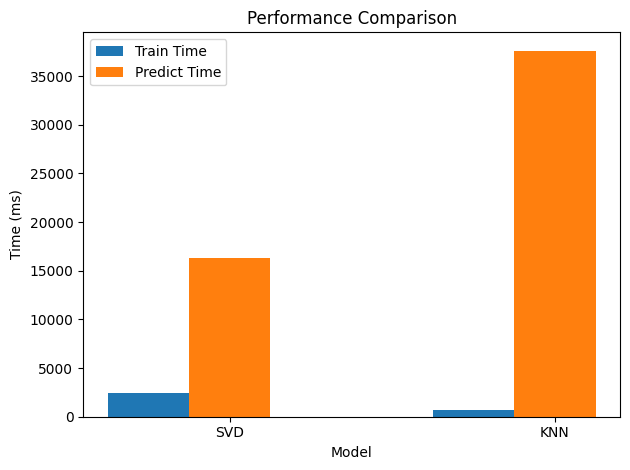

In [41]:
labels = ["SVD", "KNN"]
train_times = [train_time_svd, train_time_knn]
predict_times = [predict_time_svd, predict_time_knn]
memory_usages = [memory_usage_svd[1], memory_usage_knn[1]]

x = range(len(labels))
width = 0.25  # Bar width

fig, ax = plt.subplots()
ax.bar([p - width for p in x], train_times, width, label='Train Time')
ax.bar(x, predict_times, width, label='Predict Time')
ax.set_xlabel('Model')
ax.set_ylabel('Time (ms)')
ax.set_title('Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.savefig("time_comp.png")
plt.show()

### Average recomended movie score

Fast batch recommendations saved to 'user_recommendations.csv'


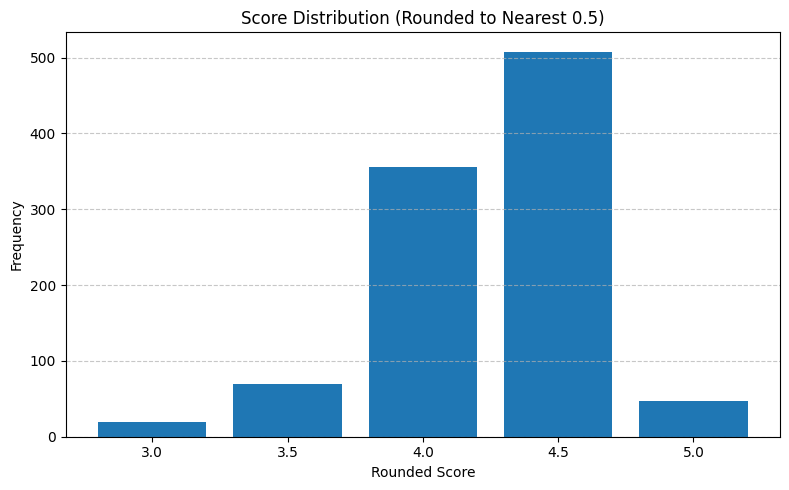

In [49]:
from collections import Counter

algo = SVD(n_factors=50, n_epochs=50, lr_all=0.001, verbose=False)
rec_df = run_model(algo, df_train, df_test, combined_dataset, keep_scores=True)

recommendation_columns = [col for col in rec_df.columns if 'recommendation' in col]
all_scores = []

for col in recommendation_columns:
    all_scores.extend(rec_df[col].apply(lambda x: x[1]))

# Step 2: Round scores to nearest 0.5
rounded_scores = [round(score * 2) / 2 for score in all_scores]

# Step 3: Count occurrences
score_counts = Counter(rounded_scores)

# Step 4: Plot
sorted_scores = sorted(score_counts.keys())
frequencies = [score_counts[score] for score in sorted_scores]

plt.figure(figsize=(8, 5))
plt.bar(sorted_scores, frequencies, width=0.4)
plt.title("Score Distribution (Rounded to Nearest 0.5)")
plt.xlabel("Rounded Score")
plt.ylabel("Frequency")
plt.xticks(sorted_scores)  # Ensure all score ticks are shown
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("score_distribution.png")
plt.show()


# Creating ratings_test.csv

In [4]:
algo = SVD(n_factors=50, n_epochs=50, lr_all=0.001, verbose=False)
rec_df = run_model(algo, combined_dataset, ratings_test_df, combined_dataset)
rec_df["userId"] = rec_df["user_id"]
del rec_df["user_id"]
rec_df.to_csv("ratings.csv", index=False)

NameError: name 'run_model' is not defined